In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jockeroika/human-bone-fractures-image-dataset")

print("Path to dataset files:", path)

c:\SSY340_DML\bone_fracture_detection\bfd\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 38.1M/38.1M [00:06<00:00, 6.48MB/s]

Extracting files...


Path to dataset files: C:\Users\toshi\.cache\kagglehub\datasets\jockeroika\human-bone-fractures-image-dataset\versions\1


In [2]:
# imports

import os
import shutil

import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
import copy

from PIL import Image

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset, Subset


In [8]:
# print(os.listdir(path))

local_folder = "./dataset3"

# os.mkdir(local_folder)

# shutil.copytree(path, local_folder, dirs_exist_ok=True)

# rename folder name

old_name =  './dataset3/fractures/Bone Fractures Detection'
new_name = './dataset3/hbfmid'

os.rename(old_name, new_name)

# folder_name = "./dataset2/fractures"
# train_target = "./dataset2/train"
# test_target = "./dataset2/test"

In [ ]:
# # Go through each class
# for class_name in os.listdir(folder_name):
#     class_path = os.path.join(folder_name, class_name)
#     if not os.path.isdir(class_path):
#         continue

#     # Define source train/test subfolders
#     src_train = os.path.join(class_path, "Train")
#     src_test = os.path.join(class_path, "Test")

#     # Define target train/test class folders
#     tgt_train_class = os.path.join(train_target, class_name)
#     tgt_test_class = os.path.join(test_target, class_name)
#     os.makedirs(tgt_train_class, exist_ok=True)
#     os.makedirs(tgt_test_class, exist_ok=True)

#     # Copy training images
#     if os.path.exists(src_train):
#         for file in os.listdir(src_train):
#             src_file = os.path.join(src_train, file)
#             dst_file = os.path.join(tgt_train_class, file)
#             if os.path.isfile(src_file):
#                 shutil.copy(src_file, dst_file)

#     # Copy testing images
#     if os.path.exists(src_test):
#         for file in os.listdir(src_test):
#             src_file = os.path.join(src_test, file)
#             dst_file = os.path.join(tgt_test_class, file)
#             if os.path.isfile(src_file):
#                 shutil.copy(src_file, dst_file)

In [27]:
# Set paths
# for yoga
train_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\train"
val_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\valid"
test_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\test"

train_img_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\train\images"
val_img_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\valid\images"
test_img_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\test\images"

train_labels_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\train\labels"
val_labels_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\valid\labels"
test_labels_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\test\labels"

# for asus
# train_dir = r"D:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\dataset2\train"
# test_dir = r"D:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\dataset2\test"

📊 Train class counts: {8: 630, 7: 66, 4: 342, 2: 54, 6: 18, 0: 168, 5: 48, 9: 120, 1: 81, 3: 21}
📊 Train class counts: {8: 65, 4: 30, 2: 7, 7: 5, 6: 3, 0: 15, 5: 7, 9: 14, 1: 10, 3: 1}
📊 Test class counts: {7: 3, 4: 17, 8: 23, 5: 2, 9: 8, 0: 9, 2: 3, 1: 1}


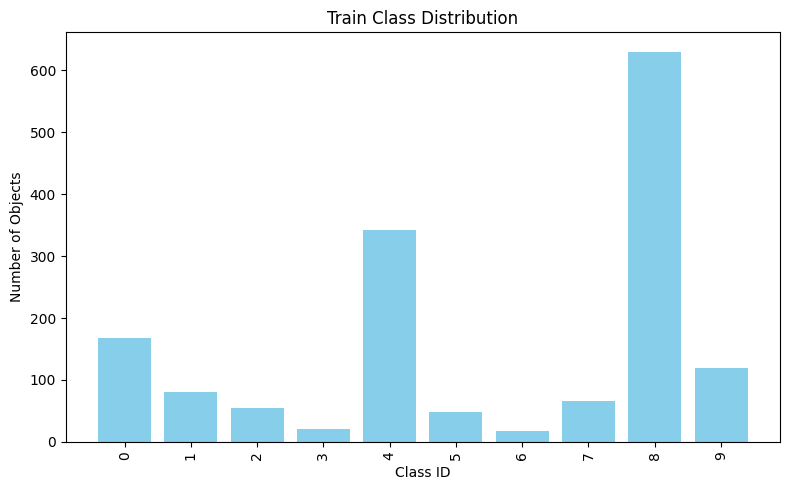

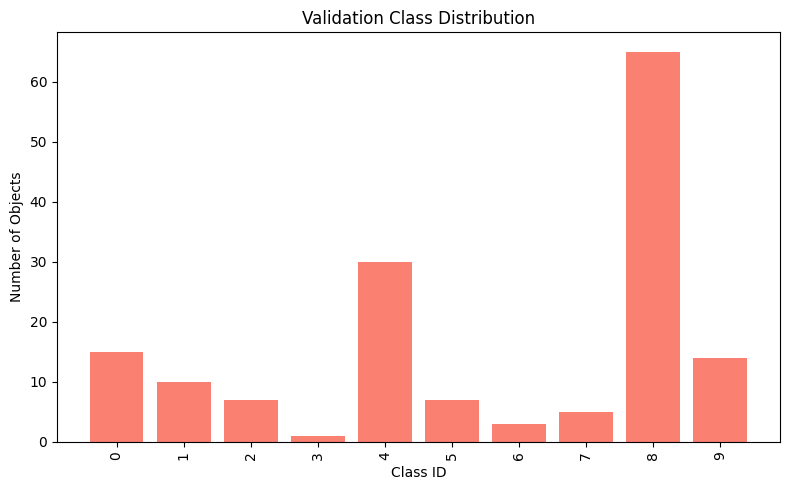

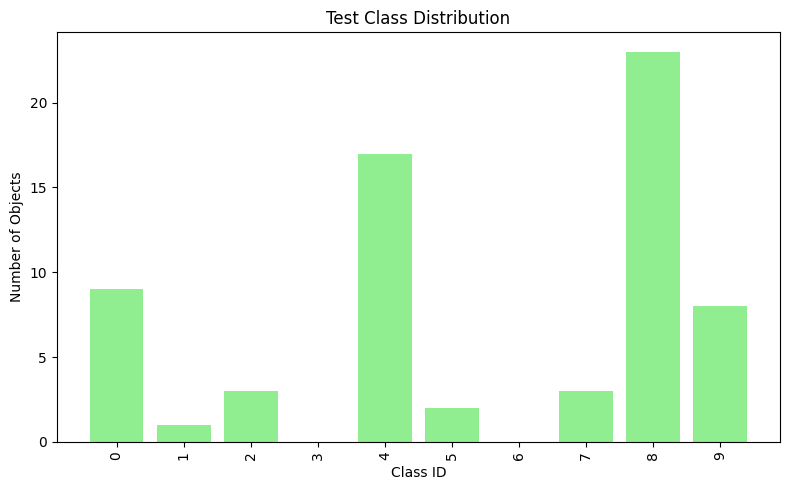

In [22]:
def count_images_in_folder(root_dir):
    class_counts = defaultdict(int)
    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            n_images = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[class_name] = n_images
    return dict(class_counts)

def count_classes_from_yolo_labels(labels_dir):
    class_counts = Counter()
    
    for txt_file in os.listdir(labels_dir):
        if txt_file.endswith('.txt'):
            file_path = os.path.join(labels_dir, txt_file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    if line.strip():  # skip empty lines
                        cls_id = int(line.strip().split()[0])
                        class_counts[cls_id] += 1
    return dict(class_counts)

# train_counts = count_classes_from_yolo_labels(train_labels_dir)
# val_counts   = count_classes_from_yolo_labels(val_labels_dir)
# test_counts  = count_classes_from_yolo_labels(test_labels_dir)

train_counts = count_classes_from_yolo_labels(train_labels_dir)
val_counts = count_classes_from_yolo_labels(val_labels_dir)
test_counts = count_classes_from_yolo_labels(test_labels_dir)

print("📊 Train class counts:", train_counts)
print("📊 Train class counts:", val_counts)
print("📊 Test class counts:", test_counts)

# Sort classes
classes = sorted(train_counts.keys())
train_values = [train_counts[c] for c in classes]
val_values   = [val_counts.get(c, 0) for c in classes]
test_values   = [test_counts.get(c, 0) for c in classes]

# --- Train plot ---
plt.figure(figsize=(8,5))
plt.bar([str(c) for c in classes], train_values, color='skyblue')
plt.title("Train Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Number of Objects")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# --- Validation plot ---
plt.figure(figsize=(8,5))
plt.bar([str(c) for c in classes], val_values, color='salmon')
plt.title("Validation Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Number of Objects")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# --- Test plot ---
plt.figure(figsize=(8,5))
plt.bar([str(c) for c in classes], test_values, color='lightgreen')
plt.title("Test Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Number of Objects")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [23]:
class FractureDataset(Dataset):
    """
    PyTorch Dataset for human bone fracture detection.
    Supports YOLO-style labels for classification + bounding boxes.
    """
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        
        # List all image files
        self.image_files = [
            f for f in os.listdir(images_dir) 
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load YOLO label
        label_path = os.path.join(self.labels_dir, os.path.splitext(img_name)[0] + '.txt')
        class_ids = []
        bboxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls_id = int(parts[0])
                        bbox = [float(x) for x in parts[1:5]]  # x_center, y_center, width, height
                        class_ids.append(cls_id)
                        bboxes.append(bbox)
        else:
            # No object in image
            class_ids.append(-1)
            bboxes.append([0,0,0,0])
        
        # Convert to tensors
        class_ids = torch.tensor(class_ids, dtype=torch.long)
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, class_ids, bboxes


# Define transforms for DeiT
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Validation / Test transforms
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

batch_size = 32

# Datasets
train_dataset = FractureDataset(train_img_dir, train_labels_dir, transform=train_transform)
val_dataset   = FractureDataset(val_img_dir, val_labels_dir, transform=val_transform)
test_dataset  = FractureDataset(test_img_dir, test_labels_dir, transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train images: {len(train_dataset)}, Val images: {len(val_dataset)}, Test images: {len(test_dataset)}")

Train images: 1347, Val images: 128, Test images: 64


# For doing both - classification and localization - together

In [38]:
# --- Helper to get class prediction ---
def output_to_label(z):
    return torch.argmax(z, dim=1)

# --- Train one epoch ---
def train_one_epoch_multitask(model, dataloader, optimizer, class_loss_fn, bbox_loss_fn,
                              device, lambda_bbox=1.0, scaler=None):
    model.train()
    total_class_loss, total_bbox_loss, total_acc = 0.0, 0.0, 0.0
    n_samples = 0

    loop = tqdm(dataloader, desc="Training", leave=False)
    for images, class_ids_list, bboxes_list in loop:
        images = images.to(device)

        # Skip images with no objects
        filtered = [(cls_ids, bbox) for cls_ids, bbox in zip(class_ids_list, bboxes_list) if len(cls_ids) > 0 and len(bbox) > 0]
        if len(filtered) == 0:
            continue
        class_ids_list, bboxes_list = zip(*filtered)

        # Take first object per image
        labels = torch.tensor([cls_ids[0] for cls_ids in class_ids_list]).to(device).long()
        bbox_targets = torch.stack([torch.tensor(b[0]) for b in bboxes_list]).to(device).float()

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            class_outputs, bbox_outputs = model(images)
            class_loss = class_loss_fn(class_outputs, labels)
            bbox_loss = bbox_loss_fn(bbox_outputs, bbox_targets)
            loss = class_loss + lambda_bbox * bbox_loss

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        preds = output_to_label(class_outputs)
        acc = (preds == labels).float().mean().item()

        total_class_loss += class_loss.item() * len(labels)
        total_bbox_loss += bbox_loss.item() * len(labels)
        total_acc += acc * len(labels)
        n_samples += len(labels)

        loop.set_postfix(class_loss=class_loss.item(), bbox_loss=bbox_loss.item(), acc=acc)

    avg_class_loss = total_class_loss / n_samples
    avg_bbox_loss = total_bbox_loss / n_samples
    avg_acc = total_acc / n_samples
    return avg_class_loss, avg_bbox_loss, avg_acc

# --- Evaluate ---
def evaluate_multitask(model, dataloader, class_loss_fn, bbox_loss_fn, device, lambda_bbox=1.0):
    model.eval()
    total_class_loss, total_bbox_loss, total_acc = 0.0, 0.0, 0.0
    n_samples = 0

    with torch.no_grad():
        loop = tqdm(dataloader, desc="Validation", leave=False)
        for images, class_ids_list, bboxes_list in loop:
            images = images.to(device)

            # Skip images with no objects
            filtered = [(cls_ids, bbox) for cls_ids, bbox in zip(class_ids_list, bboxes_list) if len(cls_ids) > 0 and len(bbox) > 0]
            if len(filtered) == 0:
                continue
            class_ids_list, bboxes_list = zip(*filtered)

            # Take first object per image
            labels = torch.tensor([cls_ids[0] for cls_ids in class_ids_list]).to(device).long()
            bbox_targets = torch.stack([torch.tensor(b[0]) for b in bboxes_list]).to(device).float()

            class_outputs, bbox_outputs = model(images)
            class_loss = class_loss_fn(class_outputs, labels)
            bbox_loss = bbox_loss_fn(bbox_outputs, bbox_targets)
            loss = class_loss + lambda_bbox * bbox_loss

            preds = output_to_label(class_outputs)
            acc = (preds == labels).float().mean().item()

            total_class_loss += class_loss.item() * len(labels)
            total_bbox_loss += bbox_loss.item() * len(labels)
            total_acc += acc * len(labels)
            n_samples += len(labels)

    avg_class_loss = total_class_loss / n_samples
    avg_bbox_loss = total_bbox_loss / n_samples
    avg_acc = total_acc / n_samples
    return avg_class_loss, avg_bbox_loss, avg_acc

# --- Multi-task training loop ---
def training_loop_multitask(model, optimizer, class_loss_fn, bbox_loss_fn,
                            train_loader, val_loader, num_epochs,
                            device=None, lambda_bbox=1.0):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    train_class_losses, train_bbox_losses, train_accs = [], [], []
    val_class_losses, val_bbox_losses, val_accs = [], [], []

    print("Starting multi-task training...\n")

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")

        # --- Gradual unfreezing for DeiT backbone ---
        if hasattr(model.backbone, 'blocks') and epoch == 15:
            print("Unfreezing last 2 DeiT blocks...")
            for param in model.backbone.blocks[-3:].parameters():
                param.requires_grad = True
            for param in model.backbone.norm.parameters():
                param.requires_grad = True
            optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-6, weight_decay=0.05)
        elif hasattr(model.backbone, 'blocks') and epoch == 30:
            print("Unfreezing last 6 DeiT blocks...")
            for param in model.backbone.blocks[-7:].parameters():
                param.requires_grad = True
            for param in model.backbone.norm.parameters():
                param.requires_grad = True

        # --- Train and Validate ---
        train_class_loss, train_bbox_loss, train_acc = train_one_epoch_multitask(
            model, train_loader, optimizer, class_loss_fn, bbox_loss_fn, device, lambda_bbox, scaler
        )
        val_class_loss, val_bbox_loss, val_acc = evaluate_multitask(
            model, val_loader, class_loss_fn, bbox_loss_fn, device, lambda_bbox
        )

        train_class_losses.append(train_class_loss)
        train_bbox_losses.append(train_bbox_loss)
        train_accs.append(train_acc)
        val_class_losses.append(val_class_loss)
        val_bbox_losses.append(val_bbox_loss)
        val_accs.append(val_acc)

        print(f"Train: Class Loss={train_class_loss:.4f}, BBox Loss={train_bbox_loss:.4f}, Acc={train_acc:.4f} | "
              f"Val: Class Loss={val_class_loss:.4f}, BBox Loss={val_bbox_loss:.4f}, Acc={val_acc:.4f}")

        # --- Save best model ---
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_multitask_model.pth")
            print("✅ Best model updated and saved.")

    print(f"\nTraining complete. Best validation accuracy: {best_val_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_class_losses, train_bbox_losses, train_accs, val_class_losses, val_bbox_losses, val_accs


In [39]:
# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Multi-task DeiT model ---
class DeiTMultiTask(nn.Module):
    def __init__(self, backbone_name='deit_base_patch16_224', num_classes=10, pretrained=True, dropout=0.3):
        super().__init__()
        # Load pretrained DeiT backbone
        self.backbone = timm.create_model(backbone_name, pretrained=pretrained)
        in_features = self.backbone.head.in_features

        # Remove original head
        self.backbone.head = nn.Identity()

        # Classification head
        self.class_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

        # Bounding box head
        self.bbox_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(dropout),
            nn.Linear(512, 4)  # x_center, y_center, width, height
        )

    def forward(self, x):
        features = self.backbone(x)  # shape [batch_size, in_features]
        class_logits = self.class_head(features)
        bbox_preds = self.bbox_head(features)
        return class_logits, bbox_preds

# --- Number of classes ---
num_classes = 10  # set according to your dataset

# --- Initialize model ---
model = DeiTMultiTask(backbone_name='deit_base_patch16_224',
                      num_classes=num_classes,
                      pretrained=True,
                      dropout=0.3).to(device)

# --- Compute class counts from YOLO-style labels ---
def get_class_counts(labels_dir):
    counts = Counter()
    for txt_file in os.listdir(labels_dir):
        if txt_file.endswith(".txt"):
            with open(os.path.join(labels_dir, txt_file), "r") as f:
                for line in f:
                    if line.strip():
                        cls_id = int(line.strip().split()[0])
                        counts[cls_id] += 1
    return counts

train_labels_dir = train_labels_dir
counts = get_class_counts(train_labels_dir)
total = sum(counts.values())

# --- Class weights ---
class_weights = torch.tensor([total / counts[i] for i in range(num_classes)], dtype=torch.float).to(device)

# --- Loss functions ---
class_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
bbox_loss_fn = nn.SmoothL1Loss()  # more stable than MSE
lambda_bbox = 1.0  # balance factor


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))


optimizer = optim.AdamW(model.parameters(), lr=8e-6,weight_decay=0.05)
num_epochs = 25
print_every = None

model, train_cls, train_bbox, train_acc, val_cls, val_bbox, val_acc = training_loop_multitask(
    model, optimizer, class_loss_fn, bbox_loss_fn,
    train_loader, val_loader, num_epochs=25,
    lambda_bbox=1.0, device=device
)



C:\Users\toshi\AppData\Local\Temp\ipykernel_24076\2994692804.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Starting multi-task training...

Epoch 1/25


RuntimeError: stack expects each tensor to be equal size, but got [1] at entry 0 and [2] at entry 12

# For only classification

In [ ]:
def output_to_label(z):
    return torch.argmax(z, dim=1)

def train_one_epoch_classification(model, dataloader, optimizer, loss_fn, device, scaler=None):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    loop = tqdm(dataloader, desc="Training", leave=False)
    for x, class_ids, _ in loop:
        x = x.to(device)
        # Take first object per image for classification
        y = torch.tensor([ids[0] for ids in class_ids]).to(device).long()

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            outputs = model(x)
            loss = loss_fn(outputs, y)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        preds = output_to_label(outputs)
        acc = (preds == y).float().mean().item()

        total_loss += loss.item()
        total_acc += acc
        loop.set_postfix(loss=loss.item(), acc=acc)

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)
    return avg_loss, avg_acc

def evaluate_classification(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    with torch.no_grad():
        loop = tqdm(dataloader, desc="Validation", leave=False)
        for x, class_ids, _ in loop:
            x = x.to(device)
            y = torch.tensor([ids[0] for ids in class_ids]).to(device).long()

            outputs = model(x)
            loss = loss_fn(outputs, y)
            preds = output_to_label(outputs)
            acc = (preds == y).float().mean().item()

            total_loss += loss.item()
            total_acc += acc

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)
    return avg_loss, avg_acc

def training_loop_classification(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, device=None, print_every=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    print("Starting classification training...\n")

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")

        # --- Gradual unfreezing for DeiT backbone ---
        if hasattr(model, 'blocks') and epoch == 15:
            print("Unfreezing last 2 DeiT blocks...")
            for param in model.blocks[-3:].parameters():
                param.requires_grad = True
            for param in model.norm.parameters():
                param.requires_grad = True
            optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-6, weight_decay=0.05)
        elif hasattr(model, 'blocks') and epoch == 30:
            print("Unfreezing last 6 DeiT blocks...")
            for param in model.blocks[-7:].parameters():
                param.requires_grad = True
            for param in model.norm.parameters():
                param.requires_grad = True

        # --- Train and Validate ---
        train_loss, train_acc = train_one_epoch_classification(model, train_loader, optimizer, loss_fn, device, scaler)
        val_loss, val_acc = evaluate_classification(model, val_loader, loss_fn, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # --- Save best model ---
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_classification_model.pth")
            print("✅ Best model updated and saved.")

    print(f"\nTraining complete. Best validation accuracy: {best_val_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accs, val_losses, val_accs


In [ ]:
model = timm.create_model('deit_base_patch16_224', pretrained=True)

model.head = nn.Linear(model.head.in_features, 10)

# Freeze all DeiT backbone parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the classification head
for param in model.head.parameters():
    param.requires_grad = True

In [ ]:
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=8e-6,weight_decay=0.05)
num_epochs = 25


model, train_losses, train_accs, val_losses, val_accs = training_loop_classification(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs)